# Optimizing a newsvendor problem with JuMP

In [1]:
using JuMP, CairoMakie
import HiGHS

Let's use a simple newspaper example

In [2]:
newspaper_cost = 5
customer_price = 7

supply = 42
demand = 40

# Daily Profit is equal to the newspapers sold less the cost we paid for it
function profit(demand, supply, customer_price, newspaper_cost) 
    return (min.(demand, supply) .* customer_price) .- (newspaper_cost .* supply)
end

# one day
single_profit = profit(demand, supply, customer_price, newspaper_cost)
println("Our Profit for one day with supply $supply is: \$ $single_profit")

Our Profit for one day with supply 42 is: $ 70


Based on this model, we set a constant daily `supply` level and calculate the profit given uncertain, fluctuating demand. How will our strategy perform over 3 days, where one day we have demand that exceeds our supply and another day in which our demand is much less than supply?

In [3]:
# two days
three_day_demand = [40, 60, 25]
multi_day_profit = profit(three_day_demand, supply, customer_price, newspaper_cost)

println("Our Profit for three days with supply $supply is: \$ $sum(multi_day_profit)")

Our Profit for three days with supply 42 is: $ sum(multi_day_profit)


We see that with the cost and sales price assumptions in this model, there's a profit hit on day 3 that brings down the 3-day profit.

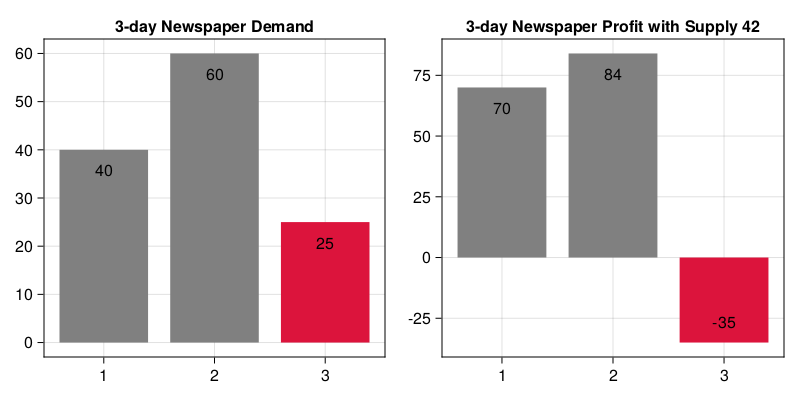

In [4]:
"""Plot Demand vs Profits"""
function plot_profit(demand, supply, profit; bar_labels=true)
        N = length(demand)
        fig = Figure(resolution=(800,400))

        ax1 = Axis(fig[1,1], title="$N-day Newspaper Demand")
        ax2 = Axis(fig[1,2], title="$N-day Newspaper Profit with Supply $supply")

        colors = [i >= 0 ? :grey : :crimson for i in profit]

        if bar_labels
                demand_labels = demand
                profit_labels = profit
        else
                demand_labels = ["" for i in demand]
                profit_labels = ["" for i in profit]
        end
        barplot!(ax1, demand, 
                bar_labels=demand_labels, 
                label_size=16,
                label_offset=-30,
                color=colors)
        barplot!(ax2, profit, 
                bar_labels=profit_labels, 
                label_size=16,
                label_offset=-30,
                color=colors)
        return fig
end

plot_profit(three_day_demand, supply, multi_day_profit)

## Finding the optimal supply level

For this example I'll use the Julia `JuMP` optimization library to find the optimal daily supply level $s$ that maximizes the total daily profit. Our first step is to convert this word problem into an optimization problem:

Let:

* $p$ = the customer price
* $d$ = demand
* $s$ = daily supply strategy
* $c$ = our newspaper cost

Then we want to maximize the sum of daily profits over $N$ days. If we have both price and cost as fixed, then we have: 

$$
\begin{aligned}
& \max \sum_i^N p* (\min(d,s)) - cs \\
&= \max \sum_i^N 7(\min(d,s)) - 5s
\end{aligned}
$$

Because $\min(d,s)$ is nonlinear, this can make finding an optimal solution a little difficult. Luckily, we have techniques to convert this problem into a linear one. [See this article on the Operations Research Stackexchange for more info.](https://or.stackexchange.com/questions/711/how-to-formulate-linearize-a-maximum-function-in-a-constraint/712#712)

First, let $x = \min(d,s)$. Then we can add some additional constraints and variables to convert this nonlinear optimization problem to a linear one:

$$
\begin{aligned}
\max & \sum_i^N 7x - 5s \\
\text{s.t.} & \\
x & \le d \\
x & \le i \\
x & \ge d - M(1-y) \\
x & \ge s - My \\
s & \ge 0 \\
y & \in \{0,1\}
\end{aligned}
$$

where $M$ is some reasonable solution. 

In [5]:
# 0. Params
demand = 40
M = 100

# 1. Establish model
model = Model(HiGHS.Optimizer)
# Option: To Suppress all the printing, use `set_silent(model)`
set_silent(model)

# 2. Variables
@variable(model, s >= 0, Int)
@variable(model, x >= 0)
@variable(model, y, Bin)

# 3. Constraints
# convert the min(d,i) nonlinear constraint to linear
@constraint(model, x <= demand)
@constraint(model, x <= s)
@constraint(model, x >= demand - M*(1-y))
@constraint(model, x >= s - M * y)

# 4. Objective Function
@objective(model, Max, (customer_price * x) - (newspaper_cost * s))

7 x - 5 s

In [6]:
# Optimize the model and print the value of $s$
optimize!(model)
value(s)

40.0

In [7]:
# What was the profit at this optimal value?
objective_value(model)

80.0

### Vectorizing in `JuMP` for multiple demand days

This code is starting to get a little messy, because of that $\min(d,s)$ constraint needs to be applied to each value of demand $d$ in an array.

To implement this in JuMP we'll need to *vectorize* the constraints and the variables.

In [8]:

"""Wrap the optimization problem within a function"""
function optimize_problem(demand)
    # 0. Params
    M = 100
    n = length(demand)

    # 1. Establish model
    model = Model(HiGHS.Optimizer)
    # Option: To Suppress all the printing, use `set_silent(model)`
    set_silent(model)

    # 2. Variables
    @variable(model, s >= 0, Int)
    @variable(model, x[i=1:n] >= 0) # Vectorize x 
    @variable(model, y[i=1:n], Bin) # Vectorize y too

    # 3. Constraints
    # convert the min(d,i) nonlinear constraint to linear
    @constraint(model, x .<= demand) 
    @constraint(model, x .<= s)
    @constraint(model, x .>= demand .- M .* (1 .- y))
    @constraint(model, x .>= s .- M .* y)

    # # 4. Objective Function
    @objective(model, Max, sum((customer_price .* x) .- (newspaper_cost .* s)))
    optimize!(model)

    return value(s)
end

optimize_problem

In [9]:
demand = [30, 30, 60, 25, 100]

optimal_supply = optimize_problem(demand)

30.0

Once again we can plot the daily profit:

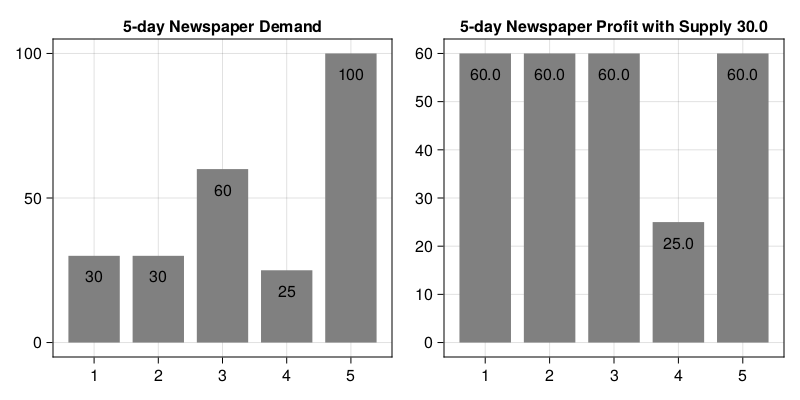

In [10]:
optimal_profits = profit(demand, optimal_supply, customer_price, newspaper_cost)

plot_profit(demand, optimal_supply, optimal_profits)

## What if demand is uncertain?

Optimizing over known demand is trivial - how would you set an optimal strategy when demand is unknown? 

We'll continue the example by randomly drawing from a demand model where demand $\sim \text{TruncatedNormal}(40, 10)$

In [11]:
using Random, Distributions

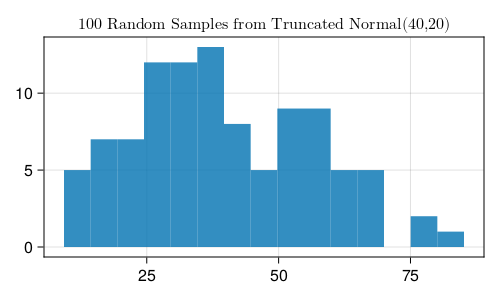

In [12]:
# set seed for reproducibility
Random.seed!(42)

# Specify the truncated distribution with truncated(dist, lower=0)
dist = truncated(Normal(40, 20), lower=0)
# Randomly sample 1000
sample_demand = rand(dist, 100)
# Plot
hist(sample_demand, 
     figure=(resolution=(500,300),),
     axis=(title=L"\text{100 Random Samples from Truncated Normal}(40,20)",))


In [13]:
random_sample_supply = optimize_problem(sample_demand)

29.0

Here our optimization problem selected a daily supply strategy of 29 newspapers. We again show the results below:

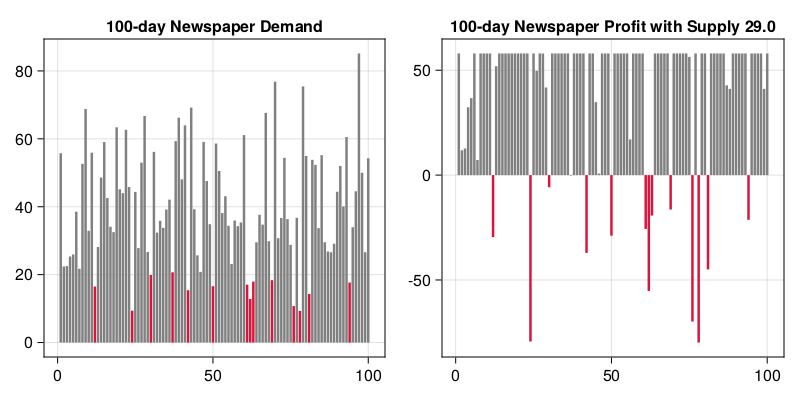

In [14]:
optimal_profits = profit(sample_demand, random_sample_supply, customer_price, newspaper_cost)

plot_profit(sample_demand, random_sample_supply, optimal_profits, bar_labels=false)

## Bayesian Statistics

How could we improve upon our assumption that demand is drawn from a $\text{TruncatedNormal}(40,20)$ distribution? If we had a few days of data we could improve upon our inventory strategy using Bayesian stats. 

Here we'll use `Turing`:

In [29]:
# Disable progress bars and such
using Turing; Turing.setprogress!(false);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/nelsontang/.julia/packages/Turing/FlV8f/src/Turing.jl:23
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/nelsontang/.julia/packages/AdvancedVI/hVQ2g/src/AdvancedVI.jl:15


We'll need to first specify our priors here. Before, we assumed the distribution had a mean $\mu=40$ and standard deviation $\sigma=20$, but with uncertain demand we don't know these parameters for certain. We'll need to specify distributions for these parameters and then sample from the posterior distribution after we get some data.

Let's say we get 5 days of observed data $d$ with an empirical mean of $\bar{d}$. We have priors as such:

$$
\begin{aligned}
\sigma & \sim \text{HalfStudentT}(\mu=10, \nu=20) \\
\mu & \sim \mathcal{N}(\bar{d}, 20) \\
\text{Demand} & \sim \text{TruncatedNormal}(\mu, \sigma, 0)\\
\end{aligned}
$$

In [16]:
demand_seen = sample_demand[1:5]
demand_unseen = sample_demand[6:15];

In [17]:
@model function newspaper(demand)
    σ ~ Truncated(TDist(20), 10, 100)
    μ ~ Normal(mean(demand_seen), 20)
    for i in 1:length(demand)
        demand[i] ~ Truncated(Normal(μ, σ), 0, 100)
    end
    return demand
end

newspaper (generic function with 2 methods)

In [18]:
idata = sample(newspaper(demand_seen), NUTS(), 1000; progress=false)

┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/nelsontang/.julia/packages/Turing/FlV8f/src/inference/hmc.jl:190
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/nelsontang/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/nelsontang/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/nelsontang/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/nelsontang/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/nelsontang/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r,

Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 7.06 seconds
Compute duration  = 7.06 seconds
parameters        = σ, μ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           σ   10.7138    0.7466     0.0236    0.0283   741.2224    1.0009     ⋯
           μ   30.0993    4.7900     0.1515    0.1848   729.7710    1.0012     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           

In [19]:
typeof(idata)

Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:start_time, :stop_time), Tuple{Float64, Float64}}}

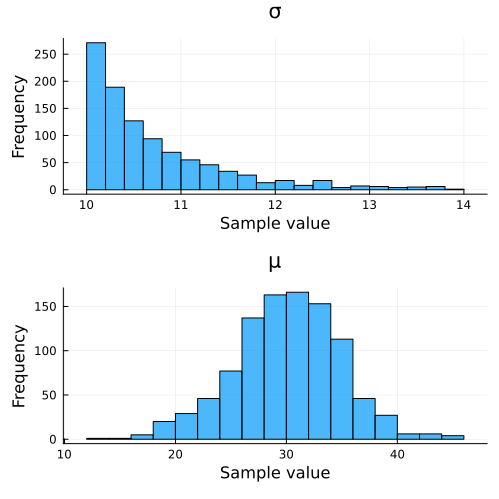

In [20]:
import Plots
Plots.histogram(idata)

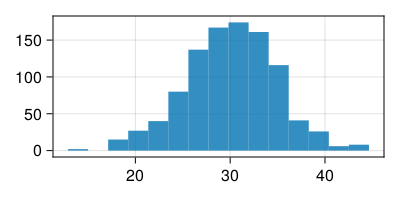

In [21]:
# You can also access the data like so:
samples = idata[:μ].data
hist(samples[1:end], figure=(resolution=(400,200),),)

In [22]:
keys(idata)

14-element Vector{Symbol}:
 :σ
 :μ
 :lp
 :n_steps
 :is_accept
 :acceptance_rate
 :log_density
 :hamiltonian_energy
 :hamiltonian_energy_error
 :max_hamiltonian_energy_error
 :tree_depth
 :numerical_error
 :step_size
 :nom_step_size

In [23]:
describe(idata)

2-element Vector{ChainDataFrame}:
 Summary Statistics (2 x 8)
 Quantiles (2 x 6)

Another way of inspecting the output is to convert it to a `DataFrame`:

In [24]:
using DataFramesMeta
first(DataFrame(idata), 10)

Row,iteration,chain,σ,μ,lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,501,1,11.2875,29.3936,-25.2256,3.0,1.0,1.87558e-6,-25.2256,31.6603,0.0,30.1024,2.0,0.0,1.11051,1.11051
2,502,1,12.8347,34.7469,-27.0374,3.0,1.0,0.398906,-27.0374,27.5185,1.02739,1.40166,2.0,0.0,1.11051,1.11051
3,503,1,10.6082,23.9739,-25.8737,3.0,1.0,0.964192,-25.8737,27.9632,-0.696942,-0.696942,2.0,0.0,1.11051,1.11051
4,504,1,10.3797,33.5923,-25.3461,3.0,1.0,0.912656,-25.3461,26.5635,-0.224364,0.303854,2.0,0.0,1.11051,1.11051
5,505,1,10.3797,33.5923,-25.3461,3.0,1.0,0.590583,-25.3461,27.0681,0.0,0.748131,2.0,0.0,1.11051,1.11051
6,506,1,11.1618,27.5725,-25.2787,3.0,1.0,1.0,-25.2787,25.4022,-0.0195941,-0.0810465,2.0,0.0,1.11051,1.11051
7,507,1,10.3686,32.9134,-25.2642,3.0,1.0,1.0,-25.2642,25.3413,-0.00163741,-0.0819738,2.0,0.0,1.11051,1.11051
8,508,1,10.9088,23.5613,-25.973,3.0,1.0,0.743265,-25.973,26.9938,0.276306,0.588385,1.0,0.0,1.11051,1.11051
9,509,1,10.3761,23.5702,-26.1859,3.0,1.0,0.917502,-26.1859,26.6893,0.141407,-0.184401,2.0,0.0,1.11051,1.11051


In [37]:
typeof(demand_seen)

Vector{Float64} (alias for Array{Float64, 1})

What we really want to get is a posterior predictive sample, though. It looks like `Turing` doesn't quite have that functionality fleshed out, but there *is* an undocumented function (see [this link](https://github.com/TuringLang/Turing.jl/blob/5990fae9f176e84d83bd119fa4a6b0e68f028493/src/inference/Inference.jl#L463))


In [32]:
@model function linear_reg(x, y, σ = 0.1)
    β ~ Normal(0, 1)
    for i ∈ eachindex(y)
        y[i] ~ Normal(β * x[i], σ)
    end
end;
σ = 0.1; 
f(x) = 2 * x + 0.1 * randn();
# Create x/y data
Δ = 0.1; 
xs_train = 0:Δ:10; ys_train = f.(xs_train);
xs_test = [10 + Δ, 10 + 2 * Δ]; ys_test = f.(xs_test);

# add observations
m_train = linear_reg(xs_train, ys_train, σ);
chain_lin_reg = sample(m_train, NUTS(100, 0.65), 200);

# Set a function parameter to `Missing` to predict it
m_test = linear_reg(xs_test, Vector{Union{Missing, Float64}}(undef, length(ys_test)), σ);
predictions = predict(m_test, chain_lin_reg)

┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/nelsontang/.julia/packages/Turing/FlV8f/src/inference/hmc.jl:190


Chains MCMC chain (200×2×1 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 1
Samples per chain = 200
parameters        = y[1], y[2]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

        y[1]   20.2274    0.0954     0.0067    0.0087   153.2982    0.9958
        y[2]   20.4225    0.1048     0.0074    0.0079   153.6657    0.9953

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        y[1]   20.0531   20.1593   20.2187   20.2850   20.4118
        y[2]   20.2046   20.3618   20.4250   20.4954   20.6124


In [31]:
ys_pred = vec(mean(Array(group(predictions, :y)); dims = 1));
sum(abs2, ys_test - ys_pred) ≤ 0.1

true

Taking from the above example, we can then call `predict` on our earlier model:

In [60]:
# See predictions for 1 additional day of demand:
demand_preds = predict(newspaper(Vector{Union{Missing, Float64}}(undef, 1)), idata)

Chains MCMC chain (1000×1×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = demand[1]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

   demand[1]   30.6618   11.6674     0.3690    0.4921   1026.1315    1.0023

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

   demand[1]    8.1583   23.0186   30.5773   38.6348   53.3413


We can plot the demand for this day here:

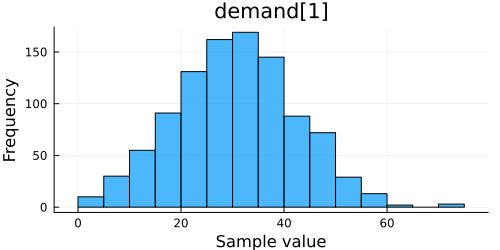

In [61]:
# We can plot the histogram directly with Plots, too
Plots.histogram(demand_preds)

And we can extract the values and optimize over this:

In [76]:
# Then the posterior predictive samples would be:
demand_samples = demand_preds[:"demand[1]"].data |> vec

bayesian_optimum_supply = optimize_problem(demand_samples)

24.0

Next we'll visualize 1000 imaginary draws from this posterior demand distribution:

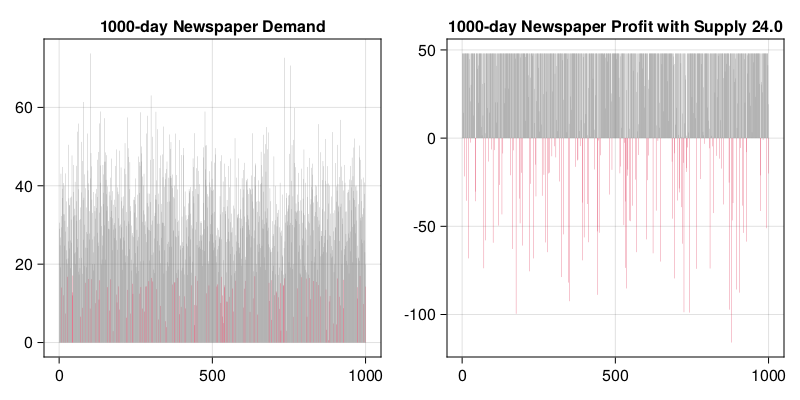

In [77]:
bayesian_optimal_profits = profit(demand_samples, bayesian_optimum_supply, customer_price, newspaper_cost)

plot_profit(demand_samples, bayesian_optimum_supply, bayesian_optimal_profits, bar_labels=false)

The title may be misleading as it's not 1000 days, rather it's 1000 possible realizations of 1 day of demand from our posterior predictive distribution.